# Ground truth generation
This Jupyter Notebook explains the process by which ground truths are extracted from both the Muscima and the Deepscores dataset. Thus, it also illustrates the process that will be used for inference.

In [1]:
import sys
# Including the source dir for relevant modules
sys.path.insert(0, '../src/autoscore/')

import cv2 as cv
import torch
from matplotlib import pyplot as plt

from os import listdir
from os.path import isfile, join

from musicdata import *

deepscores_fn = '../../data/DEEPSCORES/images_png/'
deepscores_gt_fn = '../../data/DEEPSCORES/xml_annotations/'
muscima_fn = '../../data/MUSCIMA/CvcMuscima-Distortions/'
muscima_gt_fn = '../../data/MUSCIMA/v1.0/data/cropobjects_manual/'

All the output from the deepscores.cc and muscima.cc binaries are stored in the `/datasets` directory. The output is in xml format and it describes the staff lines in the image.

In [2]:
'''
Parsing all the staff description xml files for both datasets that were 
generated by deepscores.cc and muscima.cc binaries
'''
artificial_files = [f for f in listdir(ARTIFICIAL_FN) if isfile(join(ARTIFICIAL_FN, f))]
handwritten_files = [f for f in listdir(HANDWRITTEN_FN) if isfile(join(HANDWRITTEN_FN, f))]

artificial_files = [get_music_file_from_xml(join(ARTIFICIAL_FN, f)) for f in artificial_files]
handwritten_files = [get_music_file_from_xml(join(HANDWRITTEN_FN, f)) for f in handwritten_files]

The Deepscores dataset's groundtruth is parsed and all the symbols that are polled a minimum amount of time will be kept. This number is currently set to 200 samples. 

In [3]:
artificial_glyphs_per_score = []
deepscores_content = dict()
for music_file in artificial_files: 
    glyph_list = deepscores_score_ground_truth(music_file.filename, deepscores_gt_fn)
    artificial_glyphs_per_score.append(glyph_list)
    
for glyphs_in_score in artificial_glyphs_per_score:
    for glyph in glyphs_in_score:
        if glyph.name not in deepscores_content:
            deepscores_content[glyph.name] = 1
        else:
            deepscores_content[glyph.name] += 1
    
for score, music_file in enumerate(artificial_files):
    music_file.position_glyphs(artificial_glyphs_per_score[score], deepscores_content, 1)

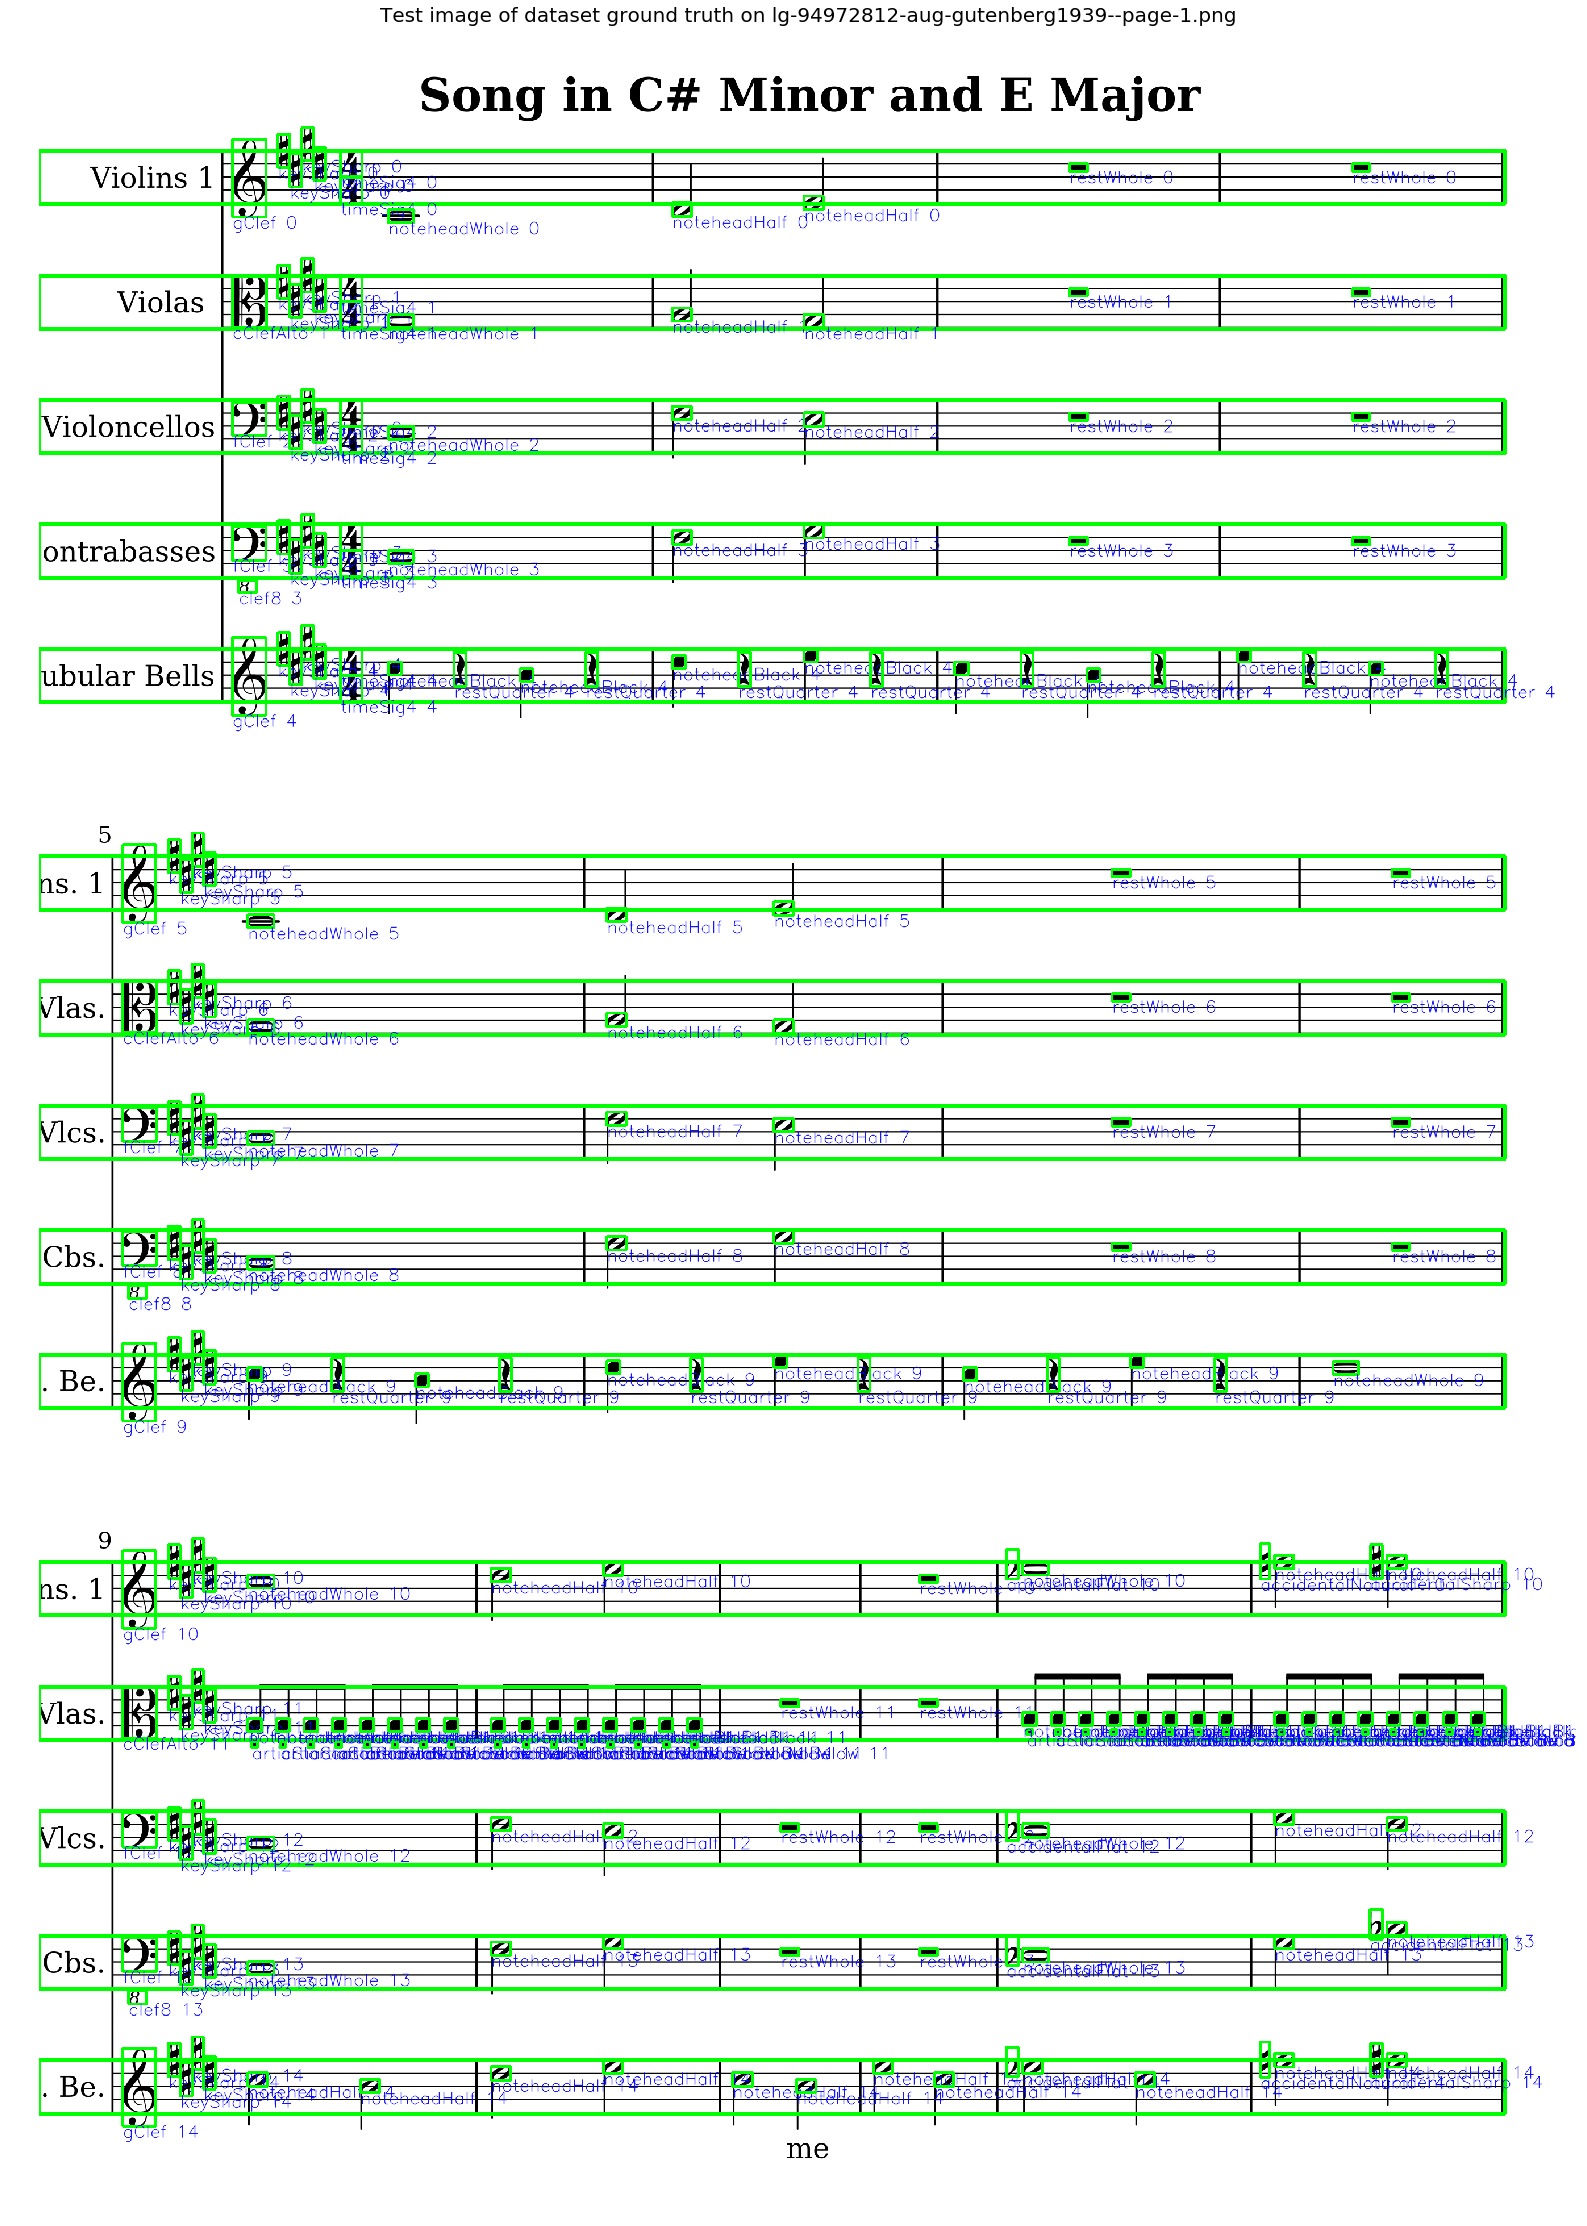

In [4]:
# Visualizing the result on one score
%matplotlib inline

test_filename = artificial_files[1].filename
img = cv.imread(join(deepscores_fn, test_filename), cv.CV_8UC1)
img = artificial_files[1].visualize(img, divs=False)
    
plt.figure(figsize=(40,40))
plt.imshow(img / 255.0);
plt.axis('off')
plt.title('Test image of dataset ground truth on {0}'.format(test_filename),
         fontsize=20);

The process is repeated for the Muscima dataset. The difference is that the Muscima dataset has annotation for only 140 music scores. Therefore, to augment the dataset, the ideal annotation is combined with some distortions for a total of 980 scores. 

In [ ]:
from datasets import sort_by_writers

sorted_handwritten_files = sort_by_writers(handwritten_files)
muscima_dict = dict()
glyphs = []
for music_file in sorted_handwritten_files: 
    filename = 'CVC-MUSCIMA_W-' + str(music_file[0]).zfill(2) + '_N-' + str(music_file[1]).zfill(2) + '_D-ideal.xml'
    glyphs.append(muscima_gt(filename, muscima_gt_fn, muscima_dict))
    
for idx, music_file in enumerate(sorted_handwritten_files):
    # Processing each distortion individually
    for file in sorted_handwritten_files[music_file]:
        file.compute_kernel()
        file.locate(glyphs[idx], muscima_dict)

In [ ]:
plt.figure(figsize=(40,40))

file = sorted_handwritten_files[list(sorted_handwritten_files.keys())[0]][0]
img = cv.imread(join(muscima_fn, file.filename), cv.CV_8UC1)
_, img = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
img = file.visualize(img, divs=False, labels=True)
plt.axis('off')
plt.imshow(img / 255.0);
plt.title('Test image of dataset ground truth on {0}'.format(file.filename),
         fontsize=20);

In [ ]:
# Printing all the labels and their count across all the datasets
for key in deepscores_dict:
    print('{0} : {1}'.format(key, deepscores_dict[key]))
print('----------------------------------------------------')
for key in muscima_dict:
    print('{0} : {1}'.format(key, muscima_dict[key]))

Then, for both datasets, a kernel of specified size is moved along the staff lines and the symbols that have at least 80% of the area of their bounding box inside that kernel will be kept. The result is a set of images that contain at least one glyph. For the case where two glyph are in the same image, the label of the most polled one is used. 

In music transcription, there is usually only one symbol vertically unless there are chords, multiple sharps/flats or staccatos. Since the goal of auto-score is mainly tablature generation, only the pitch will matter. Therefore, whenever a sharp, a flat or a note is found, the kernel is then examined vertically to find the positions of said glyphs.

In [ ]:
# Displaying the samples for training in a single image (computer generated)
file = artificial_files[0]
img = cv.imread(join(deepscores_fn, file.filename), cv.CV_8UC1)
samples = file.extract_samples(img, deepscores_dict)
print(len([sample for sample in samples if sample[1] != 'None']))
fig, axes = plt.subplots(6,6, figsize=(20,20))

i = 0
for sample in samples:
    if sample[1] == 'None':
        continue
    idx = i % len(axes), i // len(axes)
    axes[idx].imshow(sample[0] / 255.0, cmap='gray')
    axes[idx].set_title(sample[1])
    i += 1
    if i == len(axes)**2: 
        break

In [ ]:
# Displaying the samples for training in a single image (handwritten)
file = handwritten_files[0]
img = cv.imread(join(muscima_fn, file.filename), cv.CV_8UC1)
samples = file.extract_samples(img, muscima_dict, thresh=0.5)
print(len([sample for sample in samples if sample[1] != 'None']))
fig, axes = plt.subplots(6,6, figsize=(20,20))

i = 0
for sample in samples:
    if sample[1] == 'None':
        continue
    idx = i % len(axes), i // len(axes)
    axes[idx].imshow(sample[0] / 255.0, cmap='gray')
    axes[idx].set_title(sample[1])
    i += 1
    if i == len(axes)**2: 
        break